In [1]:
import os
import datetime
import random
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from category_encoders import CountEncoder

import lightgbm as lgb
#import optuna.integration.lightgbm as lgb

import geodatasets
import geopandas
from sklearn.decomposition import TruncatedSVD

import seaborn as sns
#sns.set(font='Yu Gothic')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [3]:
# Congig
SEED = 42
FOLD = 5
pd.get_option('display.max_columns')
seed_everything(SEED)

In [4]:
train = pd.read_csv('./train_kfold.csv',index_col=0)
test = pd.read_csv('./test_geo.csv',index_col=0)
sample_submission = pd.read_csv("./sample_submission.csv",index_col=0, header=None)
train.shape, test.shape

((19984, 25), (19702, 23))

### 欠損値

In [5]:
train.isnull().sum()

created_at              0
tree_dbh                0
curb_loc                0
health                  0
steward             14883
guards              14943
sidewalk                0
user_type               0
problems            12243
spc_common              0
spc_latin               0
nta                     0
nta_name                0
borocode                0
boro_ct                 0
boroname                0
zip_city                0
cb_num                  0
st_senate               0
st_assem                0
cncldist                0
combined_address        0
latitude                0
longitude               0
kfold                   0
dtype: int64

In [6]:
train.fillna('NULL', inplace=True)
train.isnull().sum()

created_at          0
tree_dbh            0
curb_loc            0
health              0
steward             0
guards              0
sidewalk            0
user_type           0
problems            0
spc_common          0
spc_latin           0
nta                 0
nta_name            0
borocode            0
boro_ct             0
boroname            0
zip_city            0
cb_num              0
st_senate           0
st_assem            0
cncldist            0
combined_address    0
latitude            0
longitude           0
kfold               0
dtype: int64

In [7]:
test.isnull().sum()

created_at              0
tree_dbh                0
curb_loc                0
steward             14526
guards              14567
sidewalk                0
user_type               0
problems            12045
spc_common              0
spc_latin               0
nta                     0
nta_name                0
borocode                0
boro_ct                 0
boroname                0
zip_city                0
cb_num                  0
st_senate               0
st_assem                0
cncldist                0
combined_address        0
latitude                0
longitude               0
dtype: int64

In [8]:
test.fillna('NULL', inplace=True)
test.isnull().sum()

created_at          0
tree_dbh            0
curb_loc            0
steward             0
guards              0
sidewalk            0
user_type           0
problems            0
spc_common          0
spc_latin           0
nta                 0
nta_name            0
borocode            0
boro_ct             0
boroname            0
zip_city            0
cb_num              0
st_senate           0
st_assem            0
cncldist            0
combined_address    0
latitude            0
longitude           0
dtype: int64

In [9]:
train.head()

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,...,boroname,zip_city,cb_num,st_senate,st_assem,cncldist,combined_address,latitude,longitude,kfold
0,2015-06-29,14,OnCurb,1,NULL,NULL,Damage,Volunteer,NULL,English oak,...,Queens,Little Neck,411,11,25,23,"Little Neck, Queens",40.774534,-73.741256,2
1,2016-09-21,5,OnCurb,1,3or4,Helpful,NoDamage,Volunteer,NULL,crimson king maple,...,Bronx,Bronx,207,33,78,15,"Bronx, Bronx",40.850656,-73.866524,3
2,2015-09-13,26,OnCurb,2,NULL,NULL,NoDamage,Volunteer,StonesBranchLights,English oak,...,Staten Island,Staten Island,503,24,62,51,"Staten Island, Staten Island",40.583456,-74.149605,2
3,2016-05-09,15,OnCurb,0,NULL,NULL,Damage,NYC Parks Staff,NULL,honeylocust,...,Staten Island,Staten Island,503,24,62,51,"Staten Island, Staten Island",40.583456,-74.149605,2
4,2016-06-24,23,OnCurb,1,NULL,NULL,NoDamage,Volunteer,Stones,London planetree,...,Manhattan,New York,110,30,70,9,"New York, Manhattan",40.789624,-73.959894,2


In [10]:
test.head()

,created_at,tree_dbh,curb_loc,steward,guards,sidewalk,user_type,problems,spc_common,spc_latin,...,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist,combined_address,latitude,longitude
0,2015-09-08,15,OnCurb,NULL,NULL,Damage,NYC Parks Staff,NULL,Callery pear,Pyrus calleryana,...,3062000,Brooklyn,Brooklyn,315,22,45,48,"Brooklyn, Brooklyn",40.652601,-73.949721
1,2015-10-15,5,OnCurb,1or2,NULL,NoDamage,Volunteer,NULL,cherry,Prunus,...,2045101,Bronx,Bronx,212,34,81,11,"Bronx, Bronx",40.850656,-73.866524
2,2016-08-03,4,OnCurb,NULL,Unsure,NoDamage,Volunteer,NULL,littleleaf linden,Tilia cordata,...,4013800,Queens,Kew Gardens,409,14,27,29,"Kew Gardens, Queens",40.713941,-73.830742
3,2015-08-06,7,OnCurb,NULL,NULL,NoDamage,TreesCount Staff,NULL,dawn redwood,Metasequoia glyptostroboides,...,3000301,Brooklyn,Brooklyn,302,26,52,33,"Brooklyn, Brooklyn",40.652601,-73.949721
4,2015-10-21,6,OnCurb,1or2,Helpful,NoDamage,TreesCount Staff,Stones,purple-leaf plum,Prunus cerasifera,...,3025100,Brooklyn,Brooklyn,303,25,56,36,"Brooklyn, Brooklyn",40.652601,-73.949721


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19984 entries, 0 to 19983
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   created_at        19984 non-null  object 
 1   tree_dbh          19984 non-null  int64  
 2   curb_loc          19984 non-null  object 
 3   health            19984 non-null  int64  
 4   steward           19984 non-null  object 
 5   guards            19984 non-null  object 
 6   sidewalk          19984 non-null  object 
 7   user_type         19984 non-null  object 
 8   problems          19984 non-null  object 
 9   spc_common        19984 non-null  object 
 10  spc_latin         19984 non-null  object 
 11  nta               19984 non-null  object 
 12  nta_name          19984 non-null  object 
 13  borocode          19984 non-null  int64  
 14  boro_ct           19984 non-null  int64  
 15  boroname          19984 non-null  object 
 16  zip_city          19984 non-null  object 
 17

## ターゲットの分布
### 木の健康状態（目的変数）
### 0:Fair（普通） 1:Good（良い） 2:Poor（悪い）

In [12]:
train["health"].value_counts()

health
1    15751
0     3535
2      698
Name: count, dtype: int64

<Axes: xlabel='health', ylabel='count'>

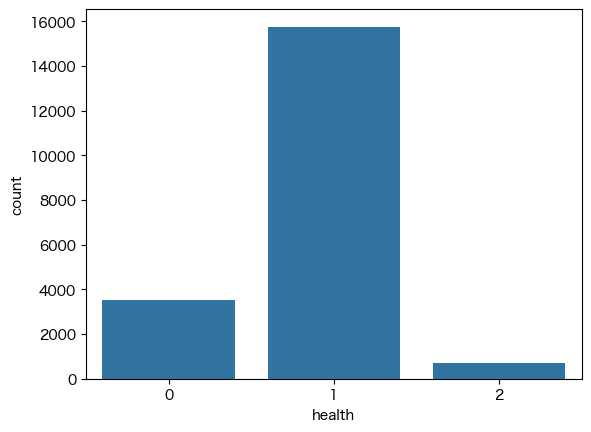

In [13]:
sns.countplot(data=train, x="health")

<Axes: xlabel='target', ylabel='count'>

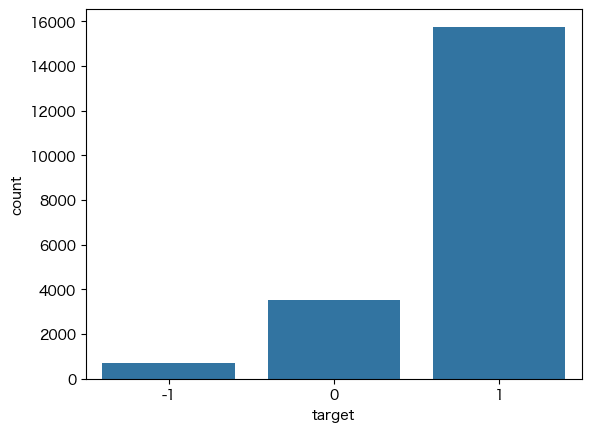

In [14]:
# For Target Enc
train["target"] = train["health"]
train["target"] = train["target"].replace(2,-1)
sns.countplot(data=train, x="target")

# 前処理部分

In [15]:
#Tag
#test["health"] = -99
test["kfold"] = -99
train["Tag"] = 1
test["Tag"] = 0

In [16]:
df_concat = pd.concat([train, test])
df_concat.shape

(39686, 27)

### 欠損値

In [17]:
df_concat.isnull().sum()

created_at              0
tree_dbh                0
curb_loc                0
health              19702
steward                 0
guards                  0
sidewalk                0
user_type               0
problems                0
spc_common              0
spc_latin               0
nta                     0
nta_name                0
borocode                0
boro_ct                 0
boroname                0
zip_city                0
cb_num                  0
st_senate               0
st_assem                0
cncldist                0
combined_address        0
latitude                0
longitude               0
kfold                   0
target              19702
Tag                     0
dtype: int64

### 多重共線性

In [18]:
# spc_latin
# nta_name
# boroname

### 特徴量作成

In [19]:
def fea_eng(df):

    # 日時
    df["created_at"] = pd.to_datetime(df["created_at"])
    df["year"] = df["created_at"].apply(lambda x: x.year)
    df["month"] = df["created_at"].apply(lambda x: x.month)
    #df["day"] = df["created_at"].apply(lambda x: x.day)
    df = df.drop('created_at',axis=1)
    
    # user_type
    df['Staff'] = df['user_type'].map(lambda x: 1 if 'Staff' in str(x) else 0)
    
    df['bool_problems'] = df['problems'].apply(lambda x: 0 if x=='NULL' else 1)

    # spc_common
    df['oak'] = df['spc_common'].map(lambda x: 1 if 'oak' in str(x) else 0)
    df['maple'] = df['spc_common'].map(lambda x: 1 if 'maple' in str(x) else 0)
    df['pine'] = df['spc_common'].map(lambda x: 1 if 'pine' in str(x) else 0)
    df['ash'] = df['spc_common'].map(lambda x: 1 if 'ash' in str(x) else 0) 
    df['white'] = df['spc_common'].map(lambda x: 1 if 'white' in str(x) else 0) 
    df['black'] = df['spc_common'].map(lambda x: 1 if 'black' in str(x) else 0) 
    df['red'] = df['spc_common'].map(lambda x: 1 if 'red' in str(x) else 0)

    # Category組み合わせ
    df["On_SIDEWALK"] = df['curb_loc'].astype(str) + "_" + df['sidewalk'].astype(str)
    df["guards_SIDEWALK"] = df['guards'].astype(str) + "_" + df['sidewalk'].astype(str)
    df["problems_SIDEWALK"] = df['problems'].astype(str) + "_" + df['sidewalk'].astype(str)      
    df["spc_SIDEWALK"] = df['spc_common'].astype(str) + "_" + df['sidewalk'].astype(str)  
    
    df["curb_NTA"] = df['curb_loc'].astype(str) + "_" + df['nta'].astype(str)
    df["guards_NTA"] = df['guards'].astype(str) + "_" + df['nta'].astype(str)     
    df["sidewalk_NTA"] = df['sidewalk'].astype(str) + "_" + df['nta'].astype(str)
    #df["user_NTA"] = df['user_type'].astype(str) + "_" + df['nta'].astype(str)
    df["problems_NTA"] = df['problems'].astype(str) + "_" + df['nta'].astype(str)
    df["spc_NTA"] = df['spc_common'].astype(str) + "_" + df['nta'].astype(str)    

    df["problems_GUARDS"] = df['problems'].astype(str) + "_" + df['guards'].astype(str)     

    return df

In [20]:
%%time
df_concat = fea_eng(df_concat)
df_concat.shape

CPU times: user 178 ms, sys: 4.66 ms, total: 183 ms
Wall time: 182 ms


(39686, 47)

In [21]:
# For Target Encoding
train = fea_eng(train)

## spc_commonごとのtree_dbh

In [22]:
temp_mean = df_concat[["tree_dbh", "spc_common"]].groupby("spc_common").mean().reset_index().rename({"tree_dbh":"Mean_tree_dbh"}, axis=1)
df_concat = df_concat.merge(temp_mean, how = "left", on = "spc_common")

In [23]:
df_concat["dbh_per_SpcAve"] = df_concat["tree_dbh"] / df_concat["Mean_tree_dbh"]
df_concat = df_concat.drop('Mean_tree_dbh',axis=1)

In [24]:
#temp_mean = df_concat[["tree_dbh", "nta"]].groupby("nta").mean().reset_index().rename({"tree_dbh":"NTA_tree_dbh"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "nta")

In [25]:
#df_concat["dbh_per_NTA"] = df_concat["tree_dbh"] / df_concat["NTA_tree_dbh"]
#df_concat = df_concat.drop('NTA_tree_dbh',axis=1)

## 位置情報

In [26]:
# 緯度、経度
df_concat['r'] = np.sqrt(df_concat['latitude']**2 + df_concat['longitude']**2)
df_concat['theta'] = np.arctan2(df_concat['latitude'], df_concat['longitude'])

In [27]:
df_concat['rot_15_x'] = (np.cos(np.radians(15)) * df_concat['longitude']) + (np.sin(np.radians(15)) * df_concat['latitude'])
df_concat['rot_15_y'] = (np.cos(np.radians(15)) * df_concat['latitude']) + (np.sin(np.radians(15)) * df_concat['longitude'])
df_concat['rot_30_x'] = (np.cos(np.radians(30)) * df_concat['longitude']) + (np.sin(np.radians(30)) * df_concat['latitude'])
df_concat['rot_30_y'] = (np.cos(np.radians(30)) * df_concat['latitude']) + (np.sin(np.radians(30)) * df_concat['longitude'])
df_concat['rot_45_x'] = (np.cos(np.radians(45)) * df_concat['longitude']) + (np.sin(np.radians(45)) * df_concat['latitude'])
df_concat['rot_45_y'] = (np.cos(np.radians(45)) * df_concat['latitude']) + (np.sin(np.radians(45)) * df_concat['longitude'])

### カラム

In [28]:
df_concat.head()

,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,spc_latin,...,problems_GUARDS,dbh_per_SpcAve,r,theta,rot_15_x,rot_15_y,rot_30_x,rot_30_y,rot_45_x,rot_45_y
0,14,OnCurb,1.0,NULL,NULL,Damage,Volunteer,NULL,English oak,Quercus robur,...,NULL_NULL,1.133911,84.263489,2.636495,-60.675358,20.299534,-43.474534,-1.558846,-23.310993,-23.310993
1,5,OnCurb,1.0,3or4,Helpful,NoDamage,Volunteer,NULL,crimson king maple,Acer platanoides 'Crimson King',...,NULL_Helpful,0.492248,84.409949,2.636424,-60.776656,20.340640,-43.544958,-1.555556,-23.345744,-23.345744
2,26,OnCurb,2.0,NULL,NULL,NoDamage,Volunteer,StonesBranchLights,English oak,Quercus robur,...,StonesBranchLights_NULL,2.105835,84.529171,2.640810,-61.119247,20.009278,-43.923714,-1.928499,-23.734852,-23.734852
3,15,OnCurb,0.0,NULL,NULL,Damage,NYC Parks Staff,NULL,honeylocust,Gleditsia triacanthos var. inermis,...,NULL_NULL,1.306129,84.529171,2.640810,-61.119247,20.009278,-43.923714,-1.928499,-23.734852,-23.734852
4,23,OnCurb,1.0,NULL,NULL,NoDamage,Volunteer,Stones,London planetree,Platanus x acerifolia,...,Stones_NULL,1.183565,84.462177,2.637591,-60.882640,20.257522,-43.656335,-1.655096,-23.454923,-23.454923


In [29]:
df_concat.columns

Index(['tree_dbh', 'curb_loc', 'health', 'steward', 'guards', 'sidewalk',
       'user_type', 'problems', 'spc_common', 'spc_latin', 'nta', 'nta_name',
       'borocode', 'boro_ct', 'boroname', 'zip_city', 'cb_num', 'st_senate',
       'st_assem', 'cncldist', 'combined_address', 'latitude', 'longitude',
       'kfold', 'target', 'Tag', 'year', 'month', 'Staff', 'bool_problems',
       'oak', 'maple', 'pine', 'ash', 'white', 'black', 'red', 'On_SIDEWALK',
       'guards_SIDEWALK', 'problems_SIDEWALK', 'spc_SIDEWALK', 'curb_NTA',
       'guards_NTA', 'sidewalk_NTA', 'problems_NTA', 'spc_NTA',
       'problems_GUARDS', 'dbh_per_SpcAve', 'r', 'theta', 'rot_15_x',
       'rot_15_y', 'rot_30_x', 'rot_30_y', 'rot_45_x', 'rot_45_y'],
      dtype='object')

In [30]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39686 entries, 0 to 39685
Data columns (total 56 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tree_dbh           39686 non-null  int64  
 1   curb_loc           39686 non-null  object 
 2   health             19984 non-null  float64
 3   steward            39686 non-null  object 
 4   guards             39686 non-null  object 
 5   sidewalk           39686 non-null  object 
 6   user_type          39686 non-null  object 
 7   problems           39686 non-null  object 
 8   spc_common         39686 non-null  object 
 9   spc_latin          39686 non-null  object 
 10  nta                39686 non-null  object 
 11  nta_name           39686 non-null  object 
 12  borocode           39686 non-null  int64  
 13  boro_ct            39686 non-null  int64  
 14  boroname           39686 non-null  object 
 15  zip_city           39686 non-null  object 
 16  cb_num             396

### Target Encoding

In [31]:
#temp_mean = train[["curb_loc", "target"]].groupby("curb_loc").mean().reset_index().rename({"target":"TE_curb_loc"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "curb_loc")
#
#temp_mean = train[["steward", "target"]].groupby("steward").mean().reset_index().rename({"target":"TE_steward"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "steward")
#
#temp_mean = train[["guards", "target"]].groupby("guards").mean().reset_index().rename({"target":"TE_guards"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "guards")
#
#temp_mean = train[["sidewalk", "target"]].groupby("sidewalk").mean().reset_index().rename({"target":"TE_sidewalk"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "sidewalk")
#
#temp_mean = train[["user_type", "target"]].groupby("user_type").mean().reset_index().rename({"target":"TE_user_type"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "user_type")
#
#temp_mean = train[["problems", "target"]].groupby("problems").mean().reset_index().rename({"target":"TE_problems"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "problems")
#
# 木の種類の一般的な名前
#temp_mean = train[["spc_common", "target"]].groupby("spc_common").mean().reset_index().rename({"target":"TE_spc_common"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "spc_common")
#
# 木のラテン名
#temp_mean = train[["spc_latin", "target"]].groupby("spc_latin").mean().reset_index().rename({"target":"TE_spc_latin"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "spc_latin")
#
# 地域（Neighborhood Tabulation Area）の略称
#temp_mean = train[["nta", "target"]].groupby("nta").mean().reset_index().rename({"target":"TE_nta"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "nta")
#
# 地域（Neighborhood Tabulation Area）の正式な名称
#temp_mean = train[["nta_name", "target"]].groupby("nta_name").mean().reset_index().rename({"target":"TE_nta_name"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "nta_name")
#
# ニューヨーク市の行政区分（ボロー）の名称
#temp_mean = train[["boroname", "target"]].groupby("boroname").mean().reset_index().rename({"target":"TE_boroname"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "boroname")
#
# 郵便番号に関連する都市または地区
#temp_mean = train[["zip_city", "target"]].groupby("zip_city").mean().reset_index().rename({"target":"TE_zip_city"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "zip_city")

## 独自
#temp_mean = train[["On_SIDEWALK", "target"]].groupby("On_SIDEWALK").mean().reset_index().rename({"target":"TE_On_SIDEWALK"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "On_SIDEWALK")
#
#temp_mean = train[["guards_SIDEWALK", "target"]].groupby("guards_SIDEWALK").mean().reset_index().rename({"target":"TE_guards_SIDEWALK"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "guards_SIDEWALK")
#
#temp_mean = train[["problems_SIDEWALK", "target"]].groupby("problems_SIDEWALK").mean().reset_index().rename({"target":"TE_problems_SIDEWALK"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "problems_SIDEWALK")
#
#temp_mean = train[["spc_SIDEWALK", "target"]].groupby("spc_SIDEWALK").mean().reset_index().rename({"target":"TE_spc_SIDEWALK"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "spc_SIDEWALK")
#
#temp_mean = train[["curb_NTA", "target"]].groupby("curb_NTA").mean().reset_index().rename({"target":"TE_curb_NTA"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "curb_NTA")
#
#temp_mean = train[["guards_NTA", "target"]].groupby("guards_NTA").mean().reset_index().rename({"target":"TE_guards_NTA"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "guards_NTA")
#
#temp_mean = train[["sidewalk_NTA", "target"]].groupby("sidewalk_NTA").mean().reset_index().rename({"target":"TE_sidewalk_NTA"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "sidewalk_NTA")
#
#temp_mean = train[["problems_NTA", "target"]].groupby("problems_NTA").mean().reset_index().rename({"target":"TE_problems_NTA"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "problems_NTA")
#
#temp_mean = train[["spc_NTA", "target"]].groupby("spc_NTA").mean().reset_index().rename({"target":"TE_spc_NTA"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "spc_NTA")
#
#temp_mean = train[["problems_GUARDS", "target"]].groupby("problems_GUARDS").mean().reset_index().rename({"target":"TE_problems_GUARDS"}, axis=1)
#df_concat = df_concat.merge(temp_mean, how = "left", on = "problems_GUARDS")

### Count Encoding

In [32]:
#categoricals = ["curb_loc", "steward", "guards", "sidewalk", "user_type","problems","spc_common","spc_latin","nta","nta_name","boroname","zip_city"]

# 欠損値のあるカテゴリ
categoricals = ["steward","guards","problems"]

for col in categoricals:
    encoder = CountEncoder()
    encoder.fit(df_concat[col])
    df_concat['%s_count'%col] = encoder.transform(df_concat[col])

### Label Encoding

In [33]:
# LabelEncoder
# 文字列を数値に変換したい
def preprocess(df):
    df["curb_loc"] = LabelEncoder().fit_transform(df["curb_loc"])
    df["steward"] = LabelEncoder().fit_transform(df["steward"])
    df["guards"] = LabelEncoder().fit_transform(df["guards"])
    df["sidewalk"] = LabelEncoder().fit_transform(df["sidewalk"])
    df["user_type"] = LabelEncoder().fit_transform(df["user_type"])
    df["problems"] = LabelEncoder().fit_transform(df["problems"])
    df["spc_common"] = LabelEncoder().fit_transform(df["spc_common"])
    df["spc_latin"] = LabelEncoder().fit_transform(df["spc_latin"])
    df["nta"] = LabelEncoder().fit_transform(df["nta"])
    df["nta_name"] = LabelEncoder().fit_transform(df["nta_name"])
    df["boroname"] = LabelEncoder().fit_transform(df["boroname"])
    df["zip_city"] = LabelEncoder().fit_transform(df["zip_city"])

    # 独自
    df["On_SIDEWALK"] = LabelEncoder().fit_transform(df["On_SIDEWALK"])
    df["guards_SIDEWALK"] = LabelEncoder().fit_transform(df["guards_SIDEWALK"])
    df["problems_SIDEWALK"] = LabelEncoder().fit_transform(df["problems_SIDEWALK"])
    df["spc_SIDEWALK"] = LabelEncoder().fit_transform(df["spc_SIDEWALK"])
    
    df["curb_NTA"] = LabelEncoder().fit_transform(df["curb_NTA"])
    df["guards_NTA"] = LabelEncoder().fit_transform(df["guards_NTA"])
    df["sidewalk_NTA"] = LabelEncoder().fit_transform(df["sidewalk_NTA"])
    #df["user_NTA"] = LabelEncoder().fit_transform(df["user_NTA"])
    df["problems_NTA"] = LabelEncoder().fit_transform(df["problems_NTA"])
    df["spc_NTA"] = LabelEncoder().fit_transform(df["spc_NTA"])

    df["problems_GUARDS"] = LabelEncoder().fit_transform(df["problems_GUARDS"])
    df["combined_address"] = LabelEncoder().fit_transform(df["combined_address"])
    return df 

In [34]:
%%time
df_concat = preprocess(df_concat)

CPU times: user 99.4 ms, sys: 1.21 ms, total: 101 ms
Wall time: 100 ms


In [35]:
df_concat.head()

,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,spc_latin,...,theta,rot_15_x,rot_15_y,rot_30_x,rot_30_y,rot_45_x,rot_45_y,steward_count,guards_count,problems_count
0,14,1,1.0,3,2,0,2,10,17,98,...,2.636495,-60.675358,20.299534,-43.474534,-1.558846,-23.310993,-23.310993,29409,29510,24288
1,5,1,1.0,1,1,1,2,10,56,7,...,2.636424,-60.776656,20.340640,-43.544958,-1.555556,-23.345744,-23.345744,2068,7366,24288
2,26,1,2.0,3,2,1,2,29,17,98,...,2.640810,-61.119247,20.009278,-43.923714,-1.928499,-23.734852,-23.734852,29409,29510,1529
3,15,1,0.0,3,2,0,0,10,73,52,...,2.640810,-61.119247,20.009278,-43.923714,-1.928499,-23.734852,-23.734852,29409,29510,24288
4,23,1,1.0,3,2,1,2,28,28,81,...,2.637591,-60.882640,20.257522,-43.656335,-1.655096,-23.454923,-23.454923,29409,29510,4455


### SVD

In [36]:
#svd = TruncatedSVD(n_components=2,random_state=SEED)
##coordinates = df_concat[['latitude','longitude','sidewalk','problems','spc_common']].values
#coordinates = df_concat[['problems','spc_common']].values
#svd.fit(coordinates)
#
#df_concat['pos_x'] = svd.transform(coordinates)[:,0]
#df_concat['pos_y'] = svd.transform(coordinates)[:,1]
#df_concat['pos_r'] = np.sqrt(df_concat['pos_x']**2 + df_concat['pos_y']**2)
#
##plot
#plt.scatter(df_concat['pos_x'],df_concat['pos_y'],c=df_concat['health'])
#plt.colorbar()
#plt.title('svd', fontsize=10)
#plt.show()

### TrainとTestに戻す

In [37]:
#data load
train = df_concat[df_concat['Tag']==1]
test = df_concat[df_concat['Tag']==0]

In [38]:
train = train.drop('Tag',axis=1)
test = test.drop('Tag',axis=1)
train.shape, test.shape

((19984, 58), (19702, 58))

In [39]:
train['id'] = train.index

In [40]:
train.head()

,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,spc_latin,...,rot_15_x,rot_15_y,rot_30_x,rot_30_y,rot_45_x,rot_45_y,steward_count,guards_count,problems_count,id
0,14,1,1.0,3,2,0,2,10,17,98,...,-60.675358,20.299534,-43.474534,-1.558846,-23.310993,-23.310993,29409,29510,24288,0
1,5,1,1.0,1,1,1,2,10,56,7,...,-60.776656,20.340640,-43.544958,-1.555556,-23.345744,-23.345744,2068,7366,24288,1
2,26,1,2.0,3,2,1,2,29,17,98,...,-61.119247,20.009278,-43.923714,-1.928499,-23.734852,-23.734852,29409,29510,1529,2
3,15,1,0.0,3,2,0,0,10,73,52,...,-61.119247,20.009278,-43.923714,-1.928499,-23.734852,-23.734852,29409,29510,24288,3
4,23,1,1.0,3,2,1,2,28,28,81,...,-60.882640,20.257522,-43.656335,-1.655096,-23.454923,-23.454923,29409,29510,4455,4


# 学習部

In [41]:
useful_features = [c for c in train.columns if c not in ("id","health", "created_at", "kfold","target","spc_latin","nta_name","boroname")]
useful_features

['tree_dbh',
 'curb_loc',
 'steward',
 'guards',
 'sidewalk',
 'user_type',
 'problems',
 'spc_common',
 'nta',
 'borocode',
 'boro_ct',
 'zip_city',
 'cb_num',
 'st_senate',
 'st_assem',
 'cncldist',
 'combined_address',
 'latitude',
 'longitude',
 'year',
 'month',
 'Staff',
 'bool_problems',
 'oak',
 'maple',
 'pine',
 'ash',
 'white',
 'black',
 'red',
 'On_SIDEWALK',
 'guards_SIDEWALK',
 'problems_SIDEWALK',
 'spc_SIDEWALK',
 'curb_NTA',
 'guards_NTA',
 'sidewalk_NTA',
 'problems_NTA',
 'spc_NTA',
 'problems_GUARDS',
 'dbh_per_SpcAve',
 'r',
 'theta',
 'rot_15_x',
 'rot_15_y',
 'rot_30_x',
 'rot_30_y',
 'rot_45_x',
 'rot_45_y',
 'steward_count',
 'guards_count',
 'problems_count']

In [42]:
# LGBMのパラメータを設定
param = {
    'device_type': 'CPU',
    'num_threads': 4,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 3, # クラスの数
    'learning_rate': 0.01,
    'verbosity': -1,
    'is_unbalance':True,
    'bagging_seed': SEED,
    'feature_fraction_seed': SEED,
    'seed': SEED,
    #'feature_pre_filter': False,
    #'lambda_l1': 7.332654771149039e-06,
    #'lambda_l2': 1.355217406974123e-07,
    #'num_leaves': 249,
    #'feature_fraction': 0.5,
    #'bagging_fraction': 0.9919569312262677,
    #'bagging_freq': 1,
    #'min_child_samples': 5
}

In [43]:
test_predictions = []
valid_predictions = {}
scores = []

for fold in range(FOLD):

    xtrain = train[train.kfold != fold].reset_index(drop=True)
    xvalid = train[train.kfold == fold].reset_index(drop=True)
    xtest = test[useful_features]

    # For Stacking
    valid_ids = xvalid.id.values.tolist()

    ytrain = xtrain.health
    yvalid = xvalid.health
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]

    # 不均衡データ対策
    lgb_train = lgb.Dataset(xtrain, ytrain,
                             weight = compute_sample_weight(class_weight='balanced',y=ytrain).astype('float32'))
    
    lgb_valid = lgb.Dataset(xvalid, yvalid)
    
    model = lgb.train(param,
                      lgb_train,
                      valid_names=['train', 'valid'],
                      valid_sets=[lgb_train, lgb_valid],
                      num_boost_round=50000,
                      callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True), lgb.log_evaluation(500)]
                      )
    
    # For Validation
    preds_valid = model.predict(xvalid,num_iteration=model.best_iteration)
    preds_valid = np.argmax(preds_valid, axis=1)  # 最尤と判断したクラスを選ぶ
    valid_predictions.update(dict(zip(valid_ids, preds_valid)))

    ###########
    # 推論部分 #
    ##########    
    # For Test
    test_preds = model.predict(xtest,num_iteration=model.best_iteration)
    test_predictions.append(test_preds)

    # F1を計算する
    score = f1_score(yvalid, preds_valid, average='macro')
    print(f'fold {fold} F1: {score}')
    scores.append(score)

    #print(model.params)

print(np.mean(scores), np.std(scores))

# For Blending and Stacking
final_valid_predictions = pd.DataFrame.from_dict(valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "LGBM_pred"]
final_valid_predictions.to_csv("train_LGBM_20231229_pred.csv", index=False)

#sample_submission.preds = np.mean(np.column_stack(test_predictions), axis=1)
#sample_submission.to_csv("test_LGBM_20230513_pred.csv",header=False,index=False)

Training until validation scores don't improve for 100 rounds
[500]	train's multi_logloss: 0.795952	valid's multi_logloss: 0.97229
[1000]	train's multi_logloss: 0.651321	valid's multi_logloss: 0.9094
[1500]	train's multi_logloss: 0.552016	valid's multi_logloss: 0.867087
[2000]	train's multi_logloss: 0.471508	valid's multi_logloss: 0.830223
[2500]	train's multi_logloss: 0.407568	valid's multi_logloss: 0.803432
[3000]	train's multi_logloss: 0.358224	valid's multi_logloss: 0.785134
[3500]	train's multi_logloss: 0.316635	valid's multi_logloss: 0.772116
[4000]	train's multi_logloss: 0.283063	valid's multi_logloss: 0.764467
[4500]	train's multi_logloss: 0.255334	valid's multi_logloss: 0.759999
[5000]	train's multi_logloss: 0.231543	valid's multi_logloss: 0.757759
Early stopping, best iteration is:
[4927]	train's multi_logloss: 0.234775	valid's multi_logloss: 0.757572
fold 0 F1: 0.35126951523608113
Training until validation scores don't improve for 100 rounds
[500]	train's multi_logloss: 0.79

### 5th Sub
cv:0.3573653589927327<BR> 
LB:0.3561516

### 4th Sub
cv:0.3561764534865773<BR>
LB:0.3538946

# 解析

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

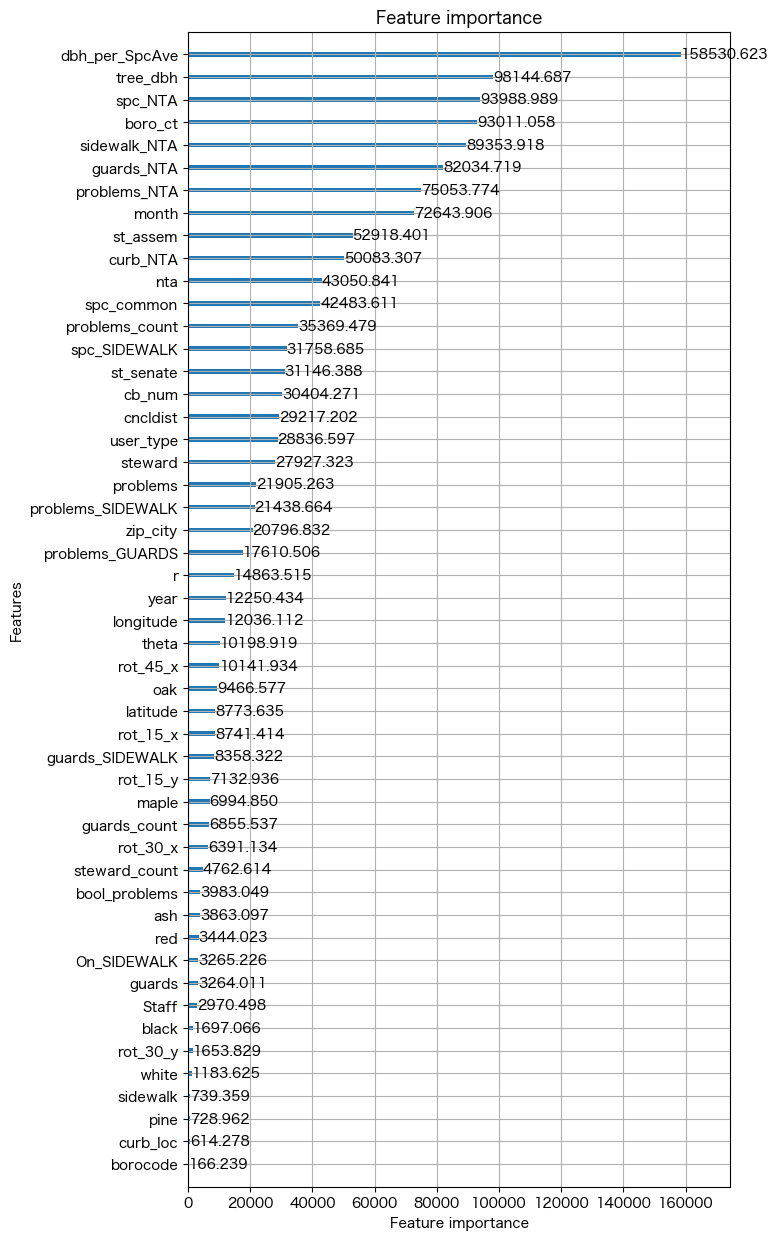

In [44]:
lgb.plot_importance(model,figsize=(7, 15), max_num_features=50, importance_type='gain')

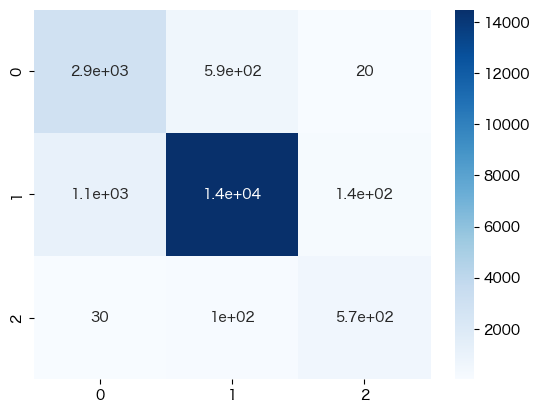

In [45]:
# confusion　matrix
train_pred = model.predict(train[useful_features], num_iteration=model.best_iteration).argmax(axis=1)
cm = confusion_matrix(train['health'], train_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.show()

## 提出

In [46]:
sample_submission.head()

,1
0,
19984,1
19985,2
19986,0
19987,1
19988,2


In [47]:
test_predictions

[array([[0.6095058 , 0.36677037, 0.02372383],
        [0.47425166, 0.49794045, 0.0278079 ],
        [0.23909254, 0.7588408 , 0.00206666],
        ...,
        [0.0584248 , 0.70095675, 0.24061845],
        [0.1572047 , 0.81571191, 0.02708338],
        [0.24620112, 0.74983349, 0.00396539]]),
 array([[8.84393752e-01, 1.15075702e-01, 5.30545405e-04],
        [1.99278528e-01, 7.91110255e-01, 9.61121711e-03],
        [5.82929822e-01, 3.99804139e-01, 1.72660385e-02],
        ...,
        [5.02667218e-02, 8.75401271e-01, 7.43320068e-02],
        [4.38016213e-01, 5.39395271e-01, 2.25885154e-02],
        [3.72322650e-01, 6.24374214e-01, 3.30313550e-03]]),
 array([[0.79381986, 0.20111088, 0.00506925],
        [0.55350747, 0.41150788, 0.03498466],
        [0.39900915, 0.57213877, 0.02885209],
        ...,
        [0.04414713, 0.92282422, 0.03302865],
        [0.23042793, 0.72220341, 0.04736865],
        [0.33100439, 0.66400404, 0.00499158]]),
 array([[0.38575451, 0.61044158, 0.00380392],
        [

In [48]:
final_test_predictions = np.average(test_predictions, axis = 0)
final_test_predictions

array([[0.66068294, 0.33221427, 0.0071028 ],
       [0.44724662, 0.53201908, 0.0207343 ],
       [0.38634047, 0.59954661, 0.01411293],
       ...,
       [0.04518036, 0.80723565, 0.14758399],
       [0.29333966, 0.67052806, 0.03613228],
       [0.27297908, 0.72346314, 0.00355778]])

In [49]:
pred = np.argmax(final_test_predictions, axis=1)  # 最尤と判断したクラスを選ぶ

In [50]:
pred

array([0, 1, 1, ..., 1, 1, 1])

In [51]:
sample_submission[1] = pred
sample_submission.head()

,1
0,
19984,0
19985,1
19986,1
19987,1
19988,0


In [52]:
#sample_submission.to_csv('./submit_1224_1st.csv', header=None)

### 木の健康状態（目的変数）
0:Fair（普通） 1:Good（良い） 2:Poor（悪い）

In [53]:
sample_submission[1].value_counts()

1
1    16561
0     2854
2      287
Name: count, dtype: int64

health<BR>
1    15751<BR>
0     3535<BR>
2      698